In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.patches import Rectangle
from scipy.stats import f_oneway
from shapely.geometry import Polygon, Point, box
import geopandas as gpd 
import osmnx as ox
from scipy import stats

import re
import h3

h3.__version__

'3.7.6'

In [2]:
raw_data_aed = pd.read_excel('001_AED信息7300_深圳AED_20230611更新.xlsx')
raw_data_xin = pd.read_excel('002_AED信息安心E站3514_已安装明细3515台6.12_20230611更新.xlsx')

# print(raw_data_aed.head(),raw_data_xin.head())

In [3]:
# Data cleaning
lat_min, lat_max = 22.2, 23.0
lng_min, lng_max = 113.5, 114.75

raw_data_xin['lat'] = raw_data_xin['纬度']
raw_data_xin['lng'] = raw_data_xin['经度']
# raw_data_xin = raw_data_xin.drop(columns=['纬度','经度','机柜编号','设备型号','AED品牌','所属区域','AED序列号','序号','安装时间','提报单位','点位类型','点位单位名称','AED主机有效期','合计安装数量','安装点位名称安装点位名称','AED电池有效期','AED电极片有效期'])
# raw_data_aed = raw_data_aed.drop(columns=['address','name'])

raw_data_xin = raw_data_xin.dropna(subset=['lat','lng'])
raw_data_aed = raw_data_aed.dropna(subset=['lat','lng'])

raw_data_xin = raw_data_xin.drop_duplicates(subset=['lat','lng'],keep='last')
raw_data_aed = raw_data_aed.drop_duplicates(subset=['lat','lng'],keep='last')

data = pd.concat([raw_data_xin,raw_data_aed])

# print(data.head())
data = data.drop_duplicates(subset=['lat','lng'],keep='last')

# print(data.info())

geo_data = data[['lat','lng']]

geo_data.reset_index(drop=True, inplace=True)
for idx, d in geo_data.iterrows():
    try:
        d['lng'] = float(d['lng'])
    except:
        try:
            deg, minutes, seconds=  re.split('[°\']', d['lng'])
            d['lng'] = (float(deg) + float(minutes)/60 + float(seconds)/(60*60))
        except:
            deg, minutes, seconds,a=  re.split('[°\'"]', d['lng'])
            d['lng'] = (float(deg) + float(minutes)/60 + float(seconds)/(60*60))
    try:
        d['lat'] = float(d['lat'])
    except:
        try:
            deg, minutes, seconds=  re.split('[°\']', d['lat'])
            d['lat'] = (float(deg) + float(minutes)/60 + float(seconds)/(60*60))
        except:
            deg, minutes, seconds,a=  re.split('[°\'"]', d['lat'])
            d['lat'] = (float(deg) + float(minutes)/60 + float(seconds)/(60*60))
    
    if d['lng'] < d['lat']:
        temp = d['lng']
        d['lng'] = d['lat']
        d['lat'] = temp
geo_data['lat'] = geo_data.apply(lambda row: float(row['lat']), axis=1)
geo_data['lng'] = geo_data.apply(lambda row: float(row['lng']), axis=1)

geo_data = geo_data[geo_data['lng']<lng_max]
geo_data = geo_data[geo_data['lng']>lng_min]
geo_data = geo_data[geo_data['lat']<lat_max]
geo_data = geo_data[geo_data['lat']>lat_min]

print(geo_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10440 entries, 0 to 10474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     10440 non-null  float64
 1   lng     10440 non-null  float64
dtypes: float64(2)
memory usage: 244.7 KB
None


/var/folders/3h/tnvbxnqx1nvftnh6jrtfqzzw0000gn/T/ipykernel_26799/1515722571.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data['lat'] = geo_data.apply(lambda row: float(row['lat']), axis=1)
/var/folders/3h/tnvbxnqx1nvftnh6jrtfqzzw0000gn/T/ipykernel_26799/1515722571.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data['lng'] = geo_data.apply(lambda row: float(row['lng']), axis=1)


get the map


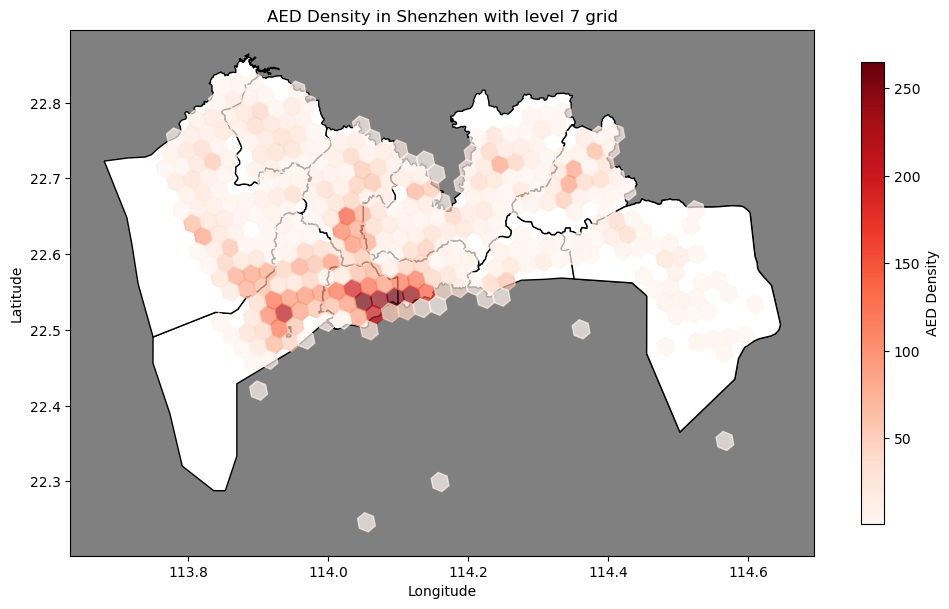

In [29]:
df = geo_data
h3_level = 7

districts = ox.geocode_to_gdf(['福田区, Shenzhen, Guangdong, China',
                               '罗湖区, Shenzhen, Guangdong, China',
                               '南山区, Shenzhen, Guangdong, China',
                               '宝安区, Shenzhen, Guangdong, China',
                               '龙岗区, Shenzhen, Guangdong, China',
                               '盐田区, Shenzhen, Guangdong, China',
                               '龙华区, Shenzhen, Guangdong, China',
                               '坪山区, Shenzhen, Guangdong, China',
                               '光明区, Shenzhen, Guangdong, China',
                               '大鹏新区, Shenzhen, Guangdong, China'])

# 繪製地圖
fig, ax = plt.subplots(figsize=(12, 12))
districts.plot(ax=ax, facecolor='white',edgecolor='black')
print('get the map')

# 使用H3來創建網格
def create_h3_grid(df, h3_level):
    df['hexagon_id'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lng'], h3_level), axis=1)
    return df


df = create_h3_grid(df, h3_level)

# 計算各網格內的AED密度
density = df['hexagon_id'].value_counts().reset_index()
density.columns = ['hexagon_id', 'count']
density.to_csv('aed_Shenzhen_h3_data.csv',index=False)

# 可視化
# fig, ax = ox.plot_graph(G, show=False, close=False)

# 繪製每個網格
for index, row in density.iterrows():
    # 將H3索引轉換為多邊形
    boundary = h3.h3_to_geo_boundary(row['hexagon_id'], geo_json=True)
    polygon = np.array(boundary)
    # 根據密度決定顏色
    color = plt.cm.Reds(row['count'] / max(density['count']))
    ax.fill(*zip(*polygon), color=color, alpha=0.7)

# 創建並顯示顏色條
norm = mcolors.Normalize(vmin=min(density['count']), vmax=max(density['count']))
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density',shrink=0.5)

# 設定地圖的界限
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'AED Density in Shenzhen with level {h3_level} grid')
ax.set_facecolor('grey')
# plt.show()

fig.savefig('AED_Shenzhen.png')


get the map


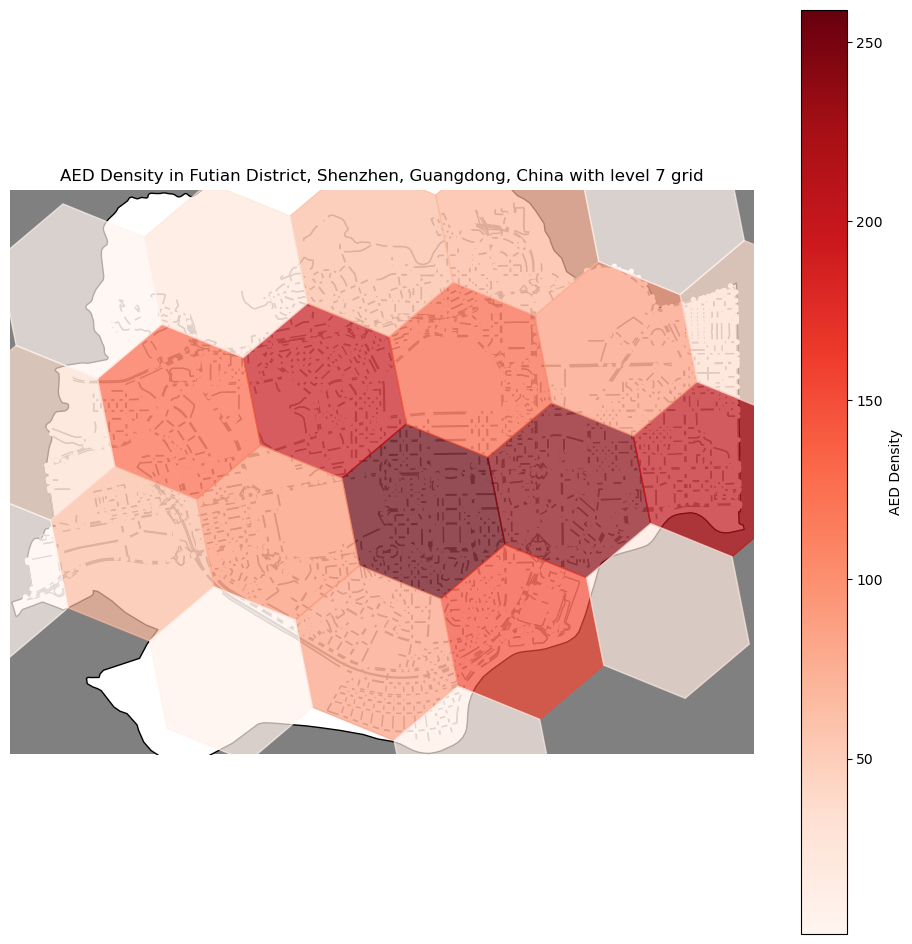

get the map


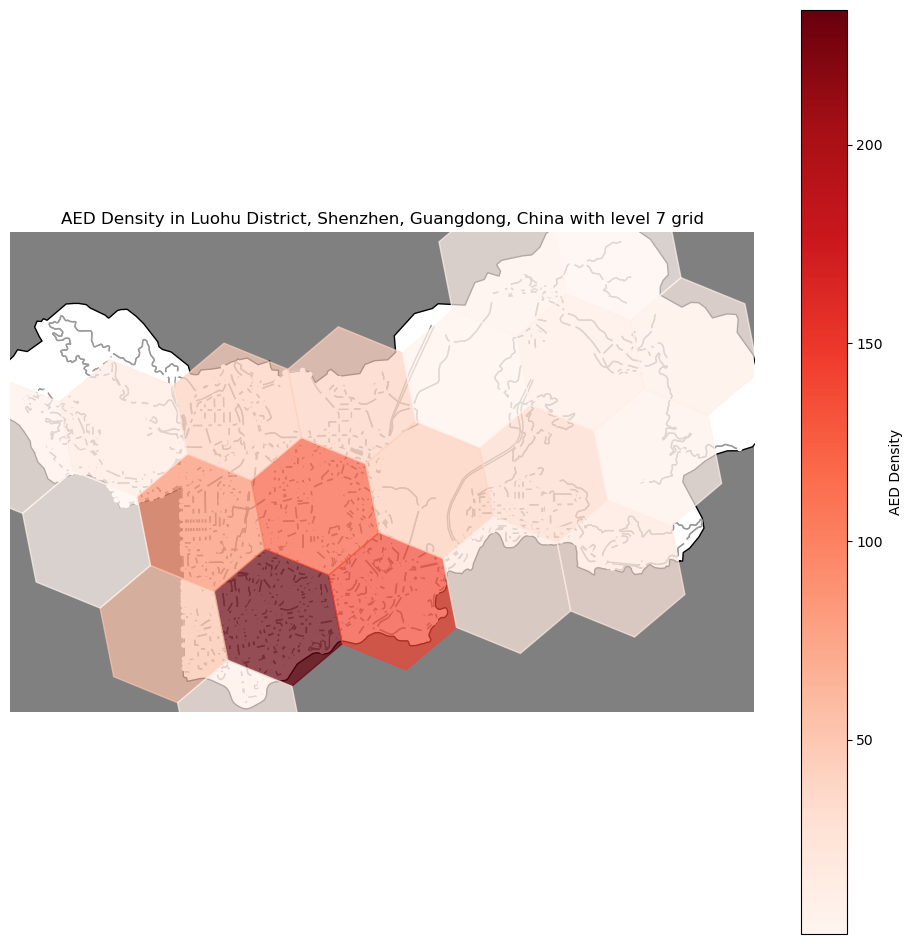

get the map


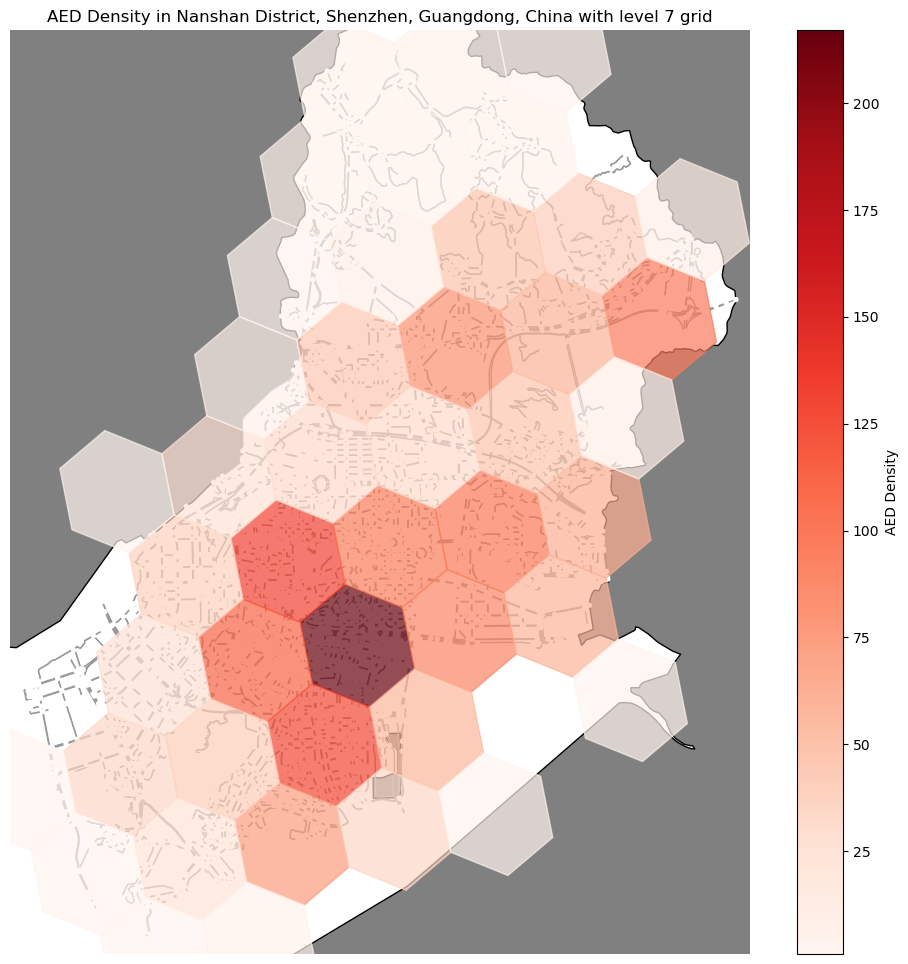

get the map


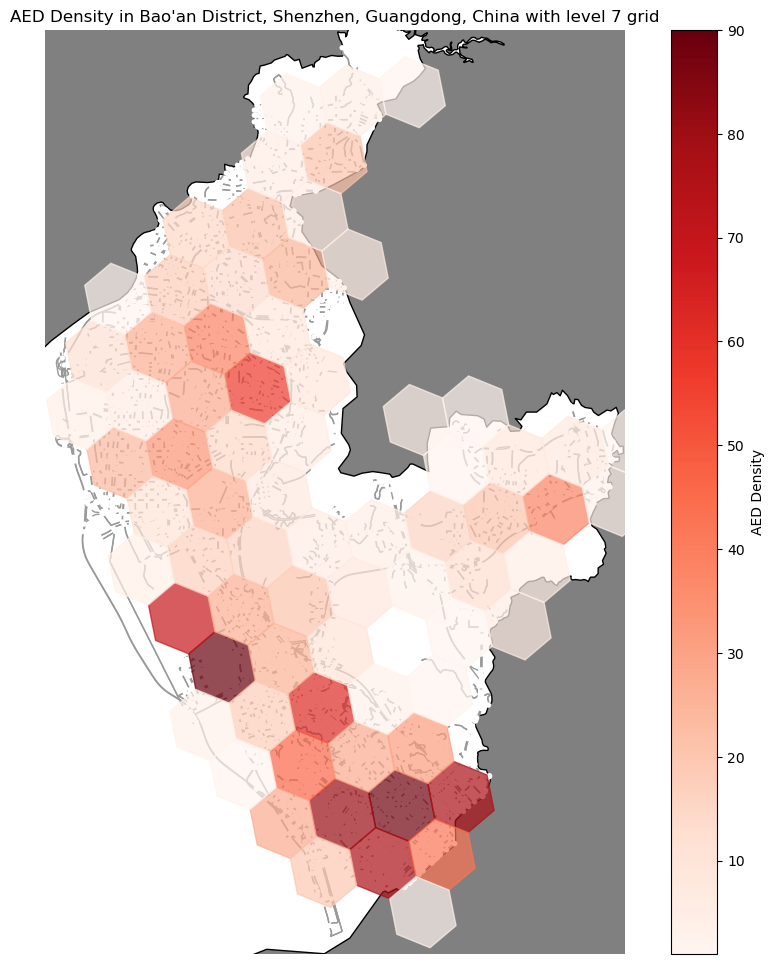

get the map


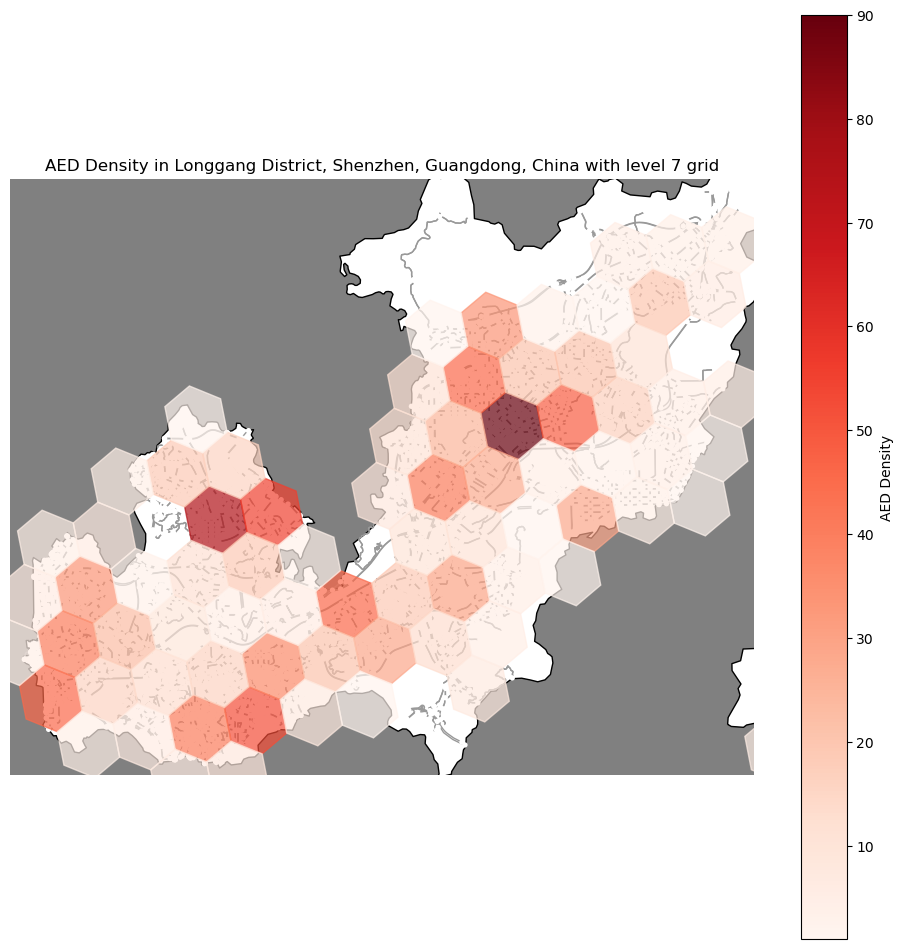

get the map


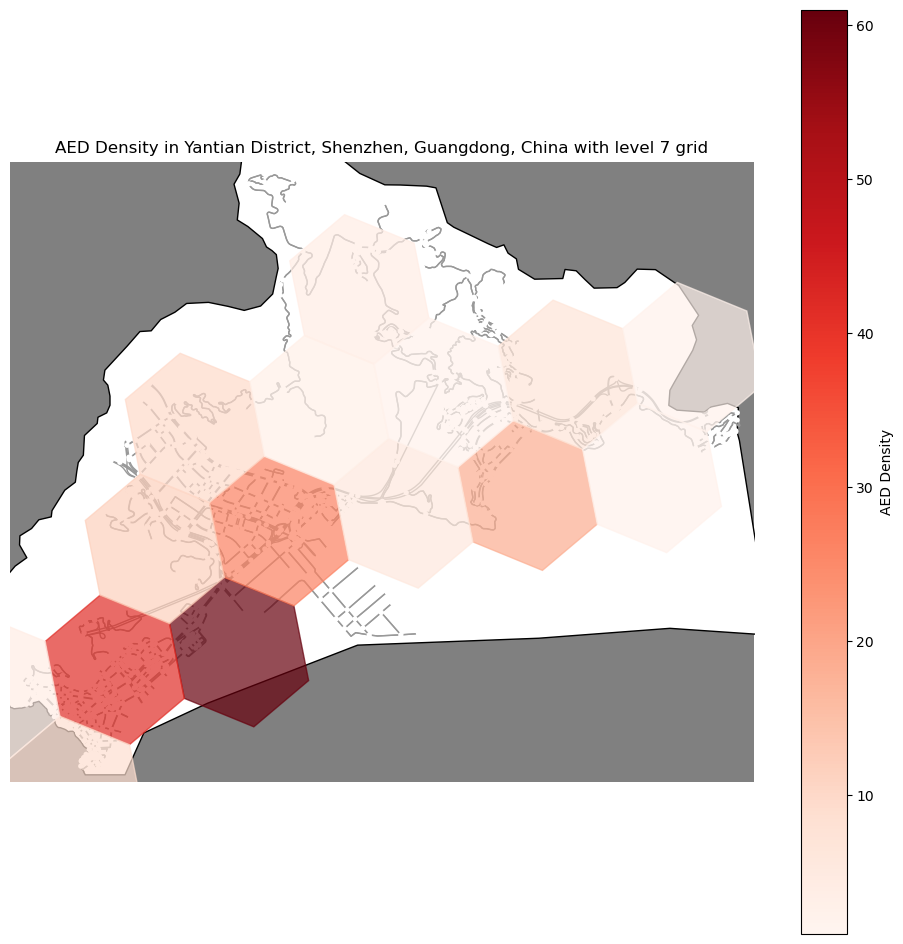

get the map


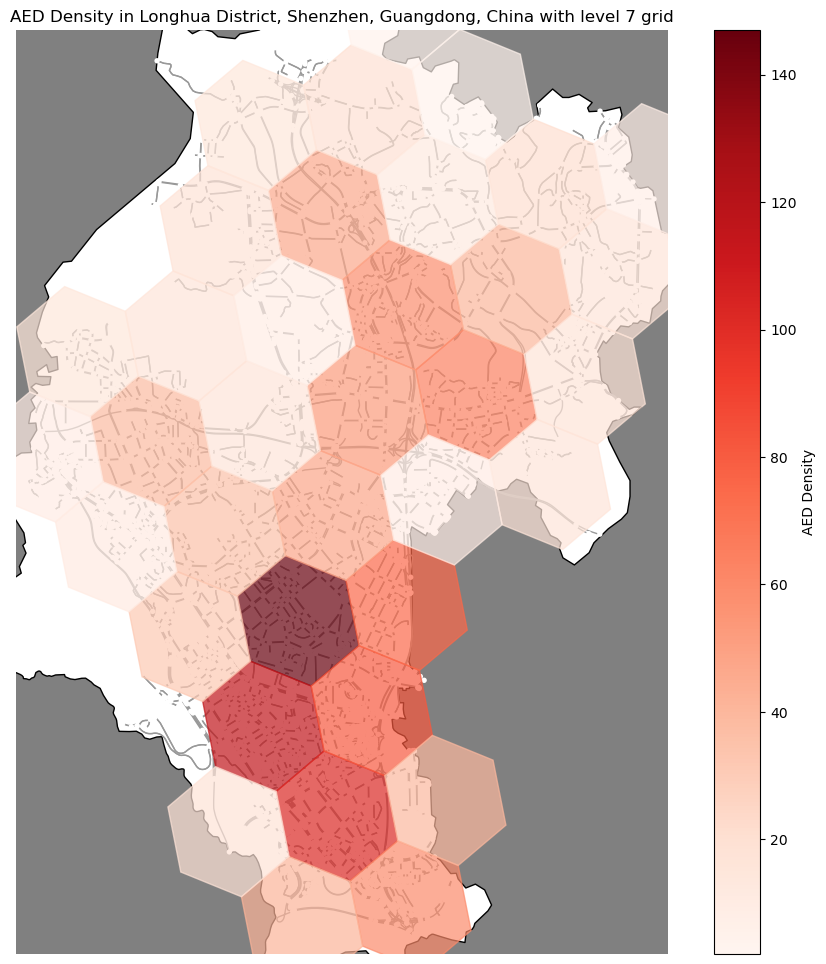

get the map


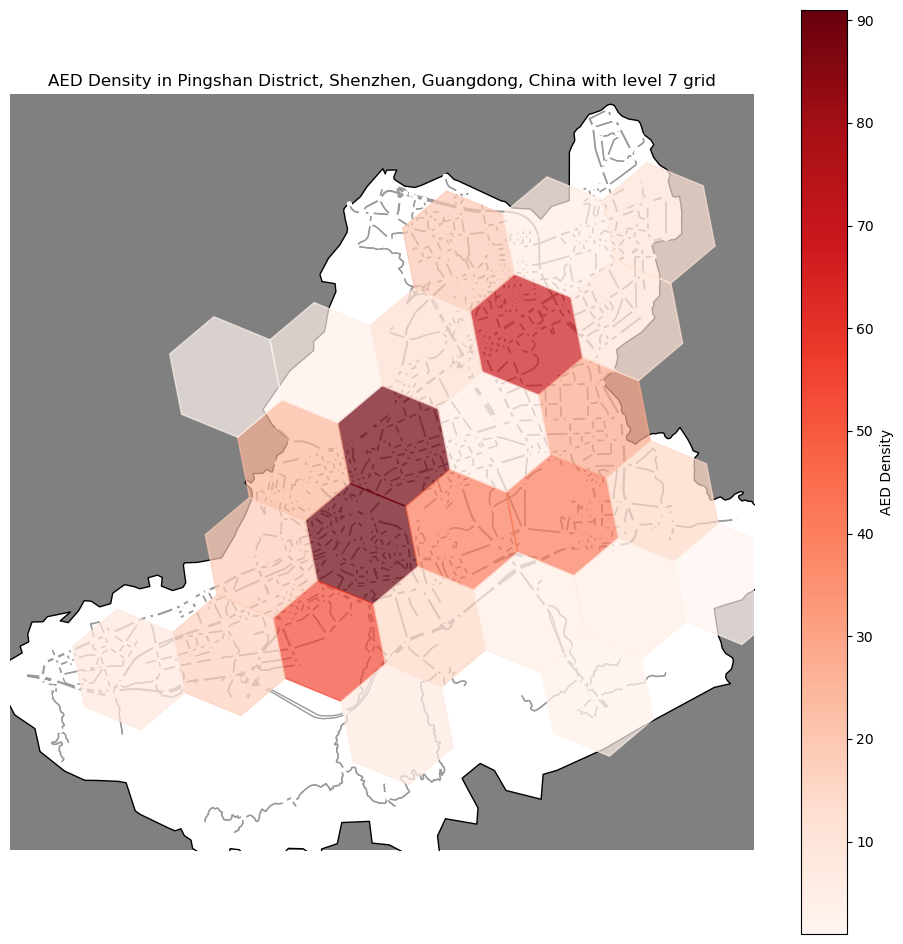

get the map


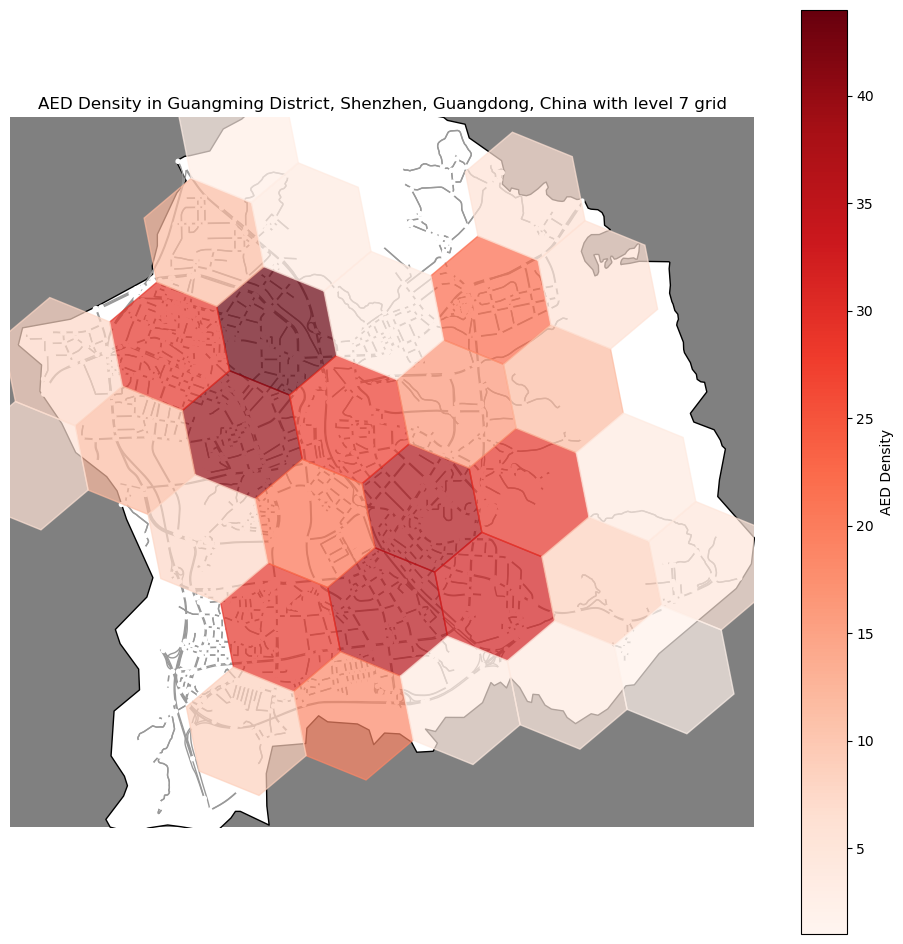

get the map


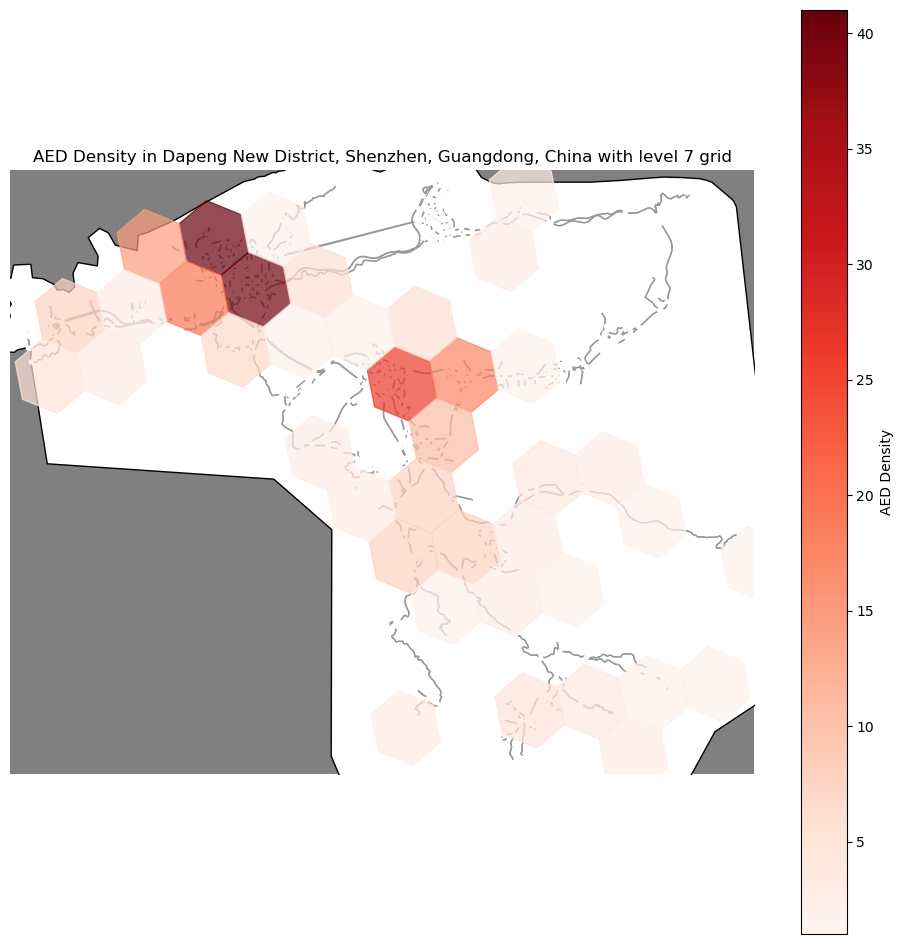

In [35]:
df = geo_data
all_districts = ['Futian District, Shenzhen, Guangdong, China',
            'Luohu District, Shenzhen, Guangdong, China',
            'Nanshan District, Shenzhen, Guangdong, China',
            "Bao'an District, Shenzhen, Guangdong, China",
            'Longgang District, Shenzhen, Guangdong, China',
            'Yantian District, Shenzhen, Guangdong, China',
            'Longhua District, Shenzhen, Guangdong, China',
            'Pingshan District, Shenzhen, Guangdong, China',
            'Guangming District, Shenzhen, Guangdong, China',
            'Dapeng New District, Shenzhen, Guangdong, China']
# district_name = districts[9]
for i in range(10):
    district_name = all_districts[i]
    # 獲取深圳市內部各個行政區的邊界 
    districts = ox.geocode_to_gdf(district_name)
    d = ox.graph_from_place(district_name, network_type='drive')

    # 繪製地圖
    fig, ax = plt.subplots(figsize=(12, 12))
    # shenzhen.plot(ax=ax, facecolor='white')
    districts.plot(ax=ax, facecolor='white',edgecolor='black')
    ox.plot_graph(d, show=False, close=False, ax=ax)
    print('get the map')

    # 使用H3來創建網格
    def create_h3_grid(df, h3_level):
        df['hexagon_id'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lng'], h3_level), axis=1)
        return df

    df = create_h3_grid(df, h3_level)

    # 篩選出位於行政區內的AED網格
    def filter_h3_indexes_within_district(df, district):
        district_polygon = district['geometry'].iloc[0]
        filtered_indexes = df[df.apply(lambda row: district_polygon.contains(gpd.GeoSeries([Point(row['lng'], row['lat'])]).iloc[0]), axis=1)]
        return filtered_indexes

    filtered_h3_indexes = filter_h3_indexes_within_district(df, districts)

    name = district_name.split(',')[0]
    # 計算各網格內的AED密度
    density = filtered_h3_indexes['hexagon_id'].value_counts().reset_index()
    density.columns = ['hexagon_id', 'count']
    density.to_csv(f'District_data/AED/AED_with_L{h3_level}_{name}.csv',index=False)

    # 繪製每個網格
    for index, row in density.iterrows():
        # 將H3索引轉換為多邊形
        boundary = h3.h3_to_geo_boundary(row['hexagon_id'], geo_json=True)
        polygon = np.array(boundary)
        # 根據密度決定顏色
        color = plt.cm.Reds(row['count'] / max(density['count']))
        ax.fill(*zip(*polygon), color=color, alpha=0.7)

    # 創建並顯示顏色條
    norm = mcolors.Normalize(vmin=min(density['count']), vmax=max(density['count']))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', label='AED Density')


    # 設定地圖的界限
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'AED Density in {district_name} with level {h3_level} grid')
    ax.set_facecolor('grey')
    plt.show()
    
    fig.savefig(f'District_data/AED/AED_with_L{h3_level}_{name}.png')


In [43]:
df = geo_data

# 使用H3來創建網格
def create_h3_grid(df, h3_level):
    df['hexagon_id'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lng'], h3_level), axis=1)
    return df

# 篩選出位於行政區內的AED網格
def filter_h3_indexes_within_district(df, districts):
    district_data = pd.DataFrame()
    for district in districts:
        dis_gdf = ox.geocode_to_gdf(district)
        district_polygon = dis_gdf['geometry'].iloc[0]
        temp = df[df.apply(lambda row: district_polygon.contains(gpd.GeoSeries([Point(row['lng'], row['lat'])]).iloc[0]), axis=1)]
        temp['District'] = district
        district_data = pd.concat([temp,district_data], ignore_index=True)
    return district_data

# 獲取深圳市的行政邊界
# shenzhen = ox.geocode_to_gdf('Shenzhen, Guangdong, China')
districts = ['Futian District, Shenzhen, Guangdong, China',
                               'Luohu District, Shenzhen, Guangdong, China',
                               'Nanshan District, Shenzhen, Guangdong, China',
                               "Bao'an District, Shenzhen, Guangdong, China",
                               'Longgang District, Shenzhen, Guangdong, China',
                               'Yantian District, Shenzhen, Guangdong, China',
                               'Longhua District, Shenzhen, Guangdong, China',
                               'Pingshan District, Shenzhen, Guangdong, China',
                               'Guangming District, Shenzhen, Guangdong, China',
                               'Dapeng New District, Shenzhen, Guangdong, China']

df = create_h3_grid(df, h3_level)
district_data = filter_h3_indexes_within_district(df, districts)

# 計算各網格內的AED密度
density = district_data['District'].value_counts().reset_index()
density.columns = ['District', 'count']

density['District'] = [i.split(',')[0] for i in density['District']]

/var/folders/3h/tnvbxnqx1nvftnh6jrtfqzzw0000gn/T/ipykernel_26799/3759831406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['District'] = district
/var/folders/3h/tnvbxnqx1nvftnh6jrtfqzzw0000gn/T/ipykernel_26799/3759831406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['District'] = district
/var/folders/3h/tnvbxnqx1nvftnh6jrtfqzzw0000gn/T/ipykernel_26799/3759831406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [44]:
density

,District,count
0,Futian District,1923
1,Nanshan District,1900
2,Longgang District,1502
3,Bao'an District,1440
4,Longhua District,1274
5,Luohu District,904
6,Pingshan District,587
7,Guangming District,481
8,Dapeng New District,256
9,Yantian District,196


              District  count
0      Futian District   1923
1     Nanshan District   1900
2    Longgang District   1502
3      Bao'an District   1440
4     Longhua District   1274
5       Luohu District    904
6    Pingshan District    587
7   Guangming District    481
8  Dapeng New District    256
9     Yantian District    196
Mean number: 1046.3
Std: 617.2738533260582
Median: 1089.0
Min number: 196
Max number: 1923
25% : 507.5
75% : 1486.5


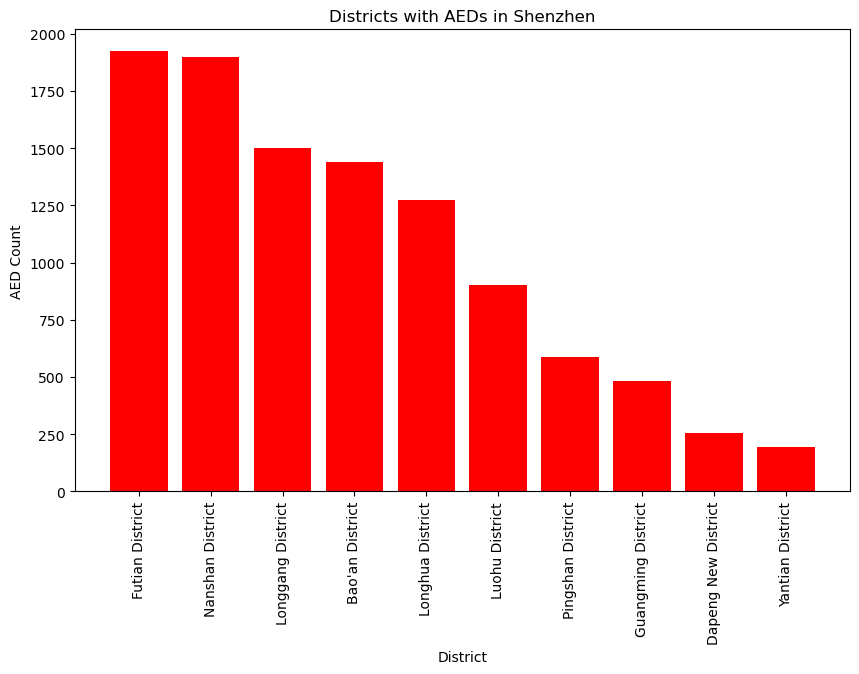

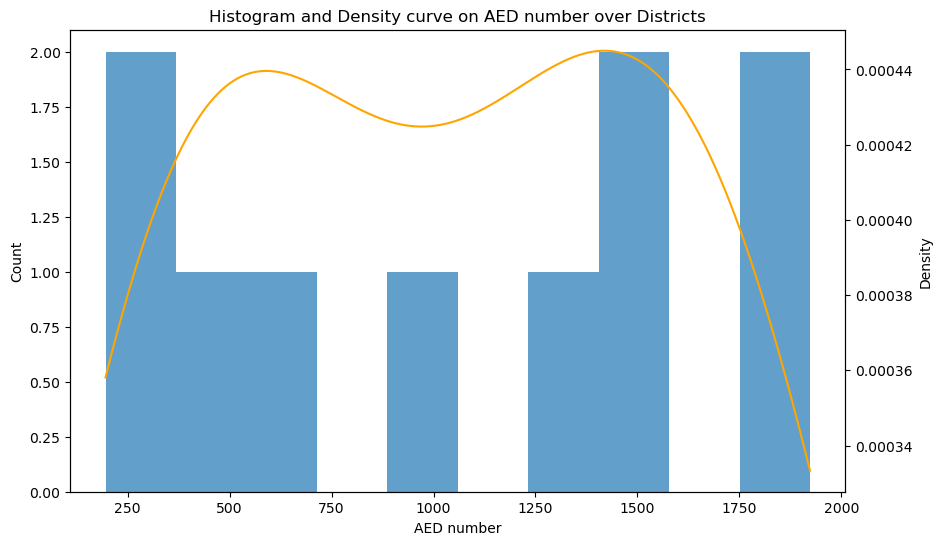

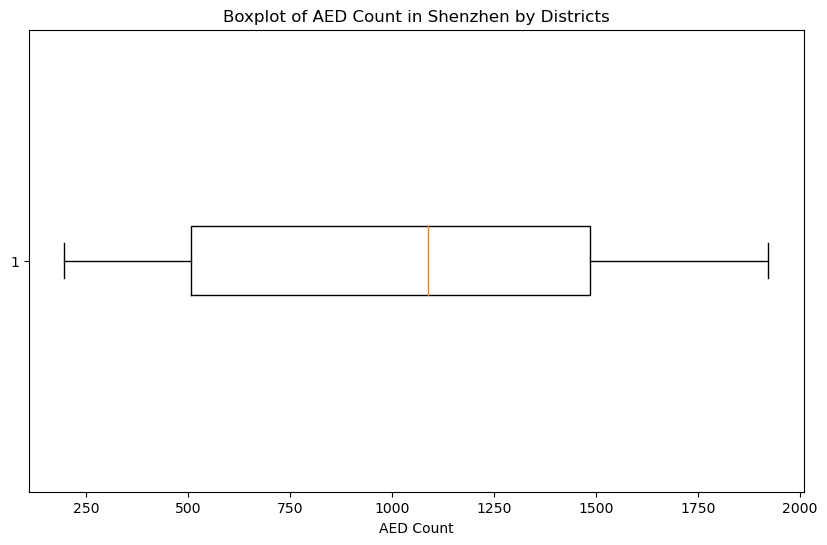

In [45]:
density_sorted = density.sort_values(by='count', ascending=False)

Number = list(density['count'])
print(density)
mean_distance = np.mean(Number)
std_distance = np.std(Number)
median_distance = np.median(Number)
min_distance = np.min(Number)
max_distance = np.max(Number)
percentile_25 = np.percentile(Number, 25)
percentile_75 = np.percentile(Number, 75)
print(f"Mean number: {mean_distance}")
print(f"Std: {std_distance}")
print(f"Median: {median_distance}")
print(f"Min number: {min_distance}")
print(f"Max number: {max_distance}")
print(f"25% : {percentile_25}")
print(f"75% : {percentile_75}")

# 繪製直條圖 
plt.figure(figsize=(10, 6))
plt.bar(density_sorted['District'], density_sorted['count'], color='red')
plt.xlabel('District')
plt.ylabel('AED Count')
plt.title('Districts with AEDs in Shenzhen')
plt.xticks(rotation=90)
plt.show()

# 繪製直條圖與密度曲線
kde = stats.gaussian_kde(Number)
xx = np.linspace(min_distance, max_distance, 1000)
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.hist(Number, bins=10,alpha=0.7)
ax2.plot(xx, kde(xx),color='orange')
ax1.set_title('Histogram and Density curve on AED number over Districts')
ax1.set_xlabel('AED number')
ax1.set_ylabel('Count')
ax2.set_ylabel('Density')

# 繪製盒狀圖
plt.figure(figsize=(10, 6))
plt.boxplot(density['count'], vert=False)
plt.xlabel('AED Count')
plt.title('Boxplot of AED Count in Shenzhen by Districts')
plt.show()


          hexagon_id  count
0    87411cb9bffffff    265
1    87411caa0ffffff    259
2    87411cb9affffff    244
3    87411caa6ffffff    242
4    87411ca1bffffff    217
..               ...    ...
355  87411c332ffffff      1
356  87411c9a3ffffff      1
357  8741034d3ffffff      1
358  87411c10bffffff      1
359  87411caceffffff      1

[360 rows x 2 columns]
Mean number: 29.0
Std: 41.46343770922361
Median: 14.0
Min number: 1
Max number: 265
25% : 4.0
75% : 38.0


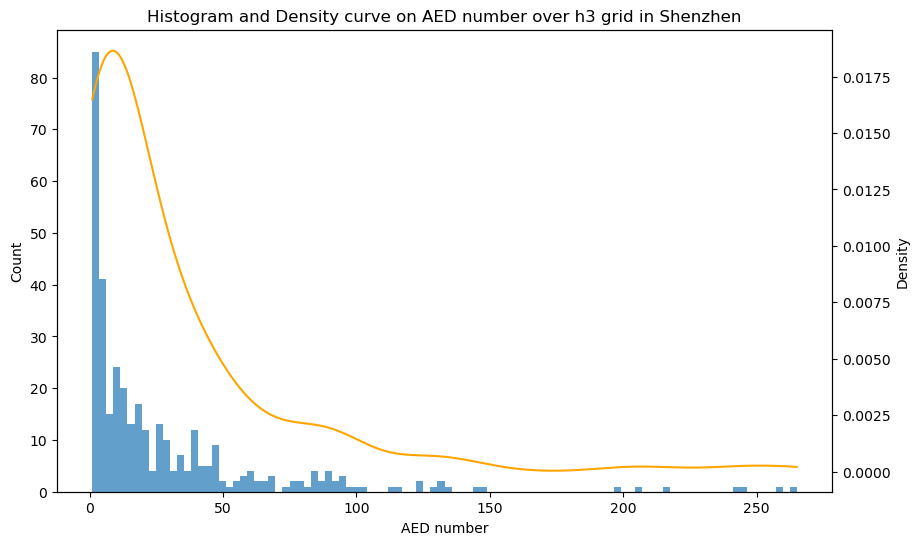

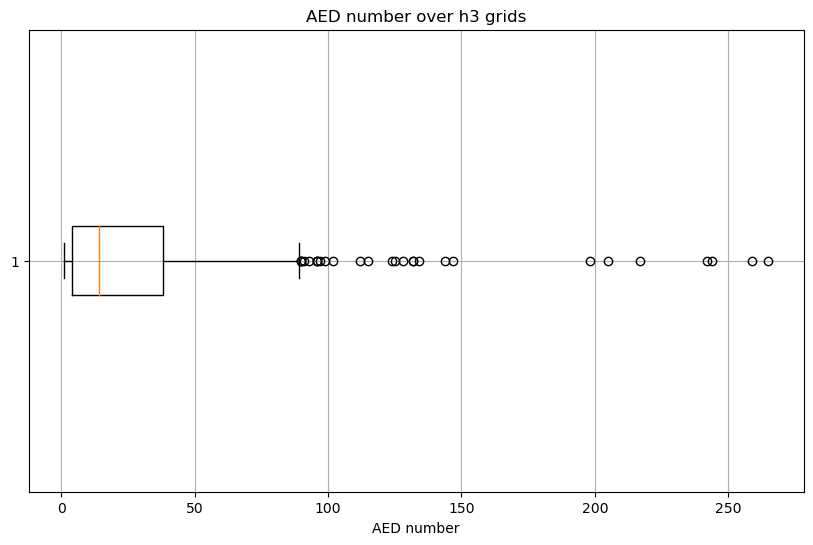

In [58]:
density = pd.read_csv('aed_Shenzhen_h3_data.csv')
bins = 100

Number = list(density['count'])
print(density)
mean_distance = np.mean(Number)
std_distance = np.std(Number)
median_distance = np.median(Number)
min_distance = np.min(Number)
max_distance = np.max(Number)
percentile_25 = np.percentile(Number, 25)
percentile_75 = np.percentile(Number, 75)

print(f"Mean number: {mean_distance}")
print(f"Std: {std_distance}")
print(f"Median: {median_distance}")
print(f"Min number: {min_distance}")
print(f"Max number: {max_distance}")
print(f"25% : {percentile_25}")
print(f"75% : {percentile_75}")

# 繪製直條圖與密度曲線
kde = stats.gaussian_kde(Number)
xx = np.linspace(min_distance, max_distance, 1000)
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

ax1.hist(Number, bins=bins,alpha=0.7)
ax2.plot(xx, kde(xx),color='orange')
ax1.set_title('Histogram and Density curve on AED number over h3 grid in Shenzhen')
ax1.set_xlabel('AED number')
ax1.set_ylabel('Count')
ax2.set_ylabel('Density')

histogram_data = pd.DataFrame(columns=['bins','count'])

gap = np.linspace(min_distance, max_distance, bins)
hist, edges = np.histogram(
    Number,
    bins=bins,
    range=(0, (max_distance-min_distance)/bins*bins),
    density=False)

histogram_data['bins'] = gap
histogram_data['count'] = hist

histogram_data.to_csv(f'AED_hist_data_{bins}_bins', index = True)

plt.figure(figsize=(10, 6))
plt.boxplot(Number, vert=False)
plt.title('AED number over h3 grids')
plt.xlabel("AED number")
plt.grid(True)
plt.show()